In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

### What to watch on Netflix ?
#### Find similar movies / tv shows using text similarity techniques
Netflix is known for its strong recommendation engines. They use a mix of content-based and collaborative filtering models to recommend tv shows and movies. In this task, one can create a recommendation engine based on text/description similarity techniques.

### Recommendation engine with a graph
>The purpose is to build a recommendation engine based on graph by using the Adamic Adar measure.<br/> The more the measure is high, the closest are the two nodes.<br/> The measures between all movies are NOT pre-calculated, in order to determine the list of recommendation films, we are going to explore the neighborhood of the target film

### How to take in account of the description ?

#### First idea ...
> In order to take in account the description, the movie are clustered by applying a KMeans clustering with TF-IDF weights <br/> So two movies that belong in a group of description will share a node.<br/> The fewer the number of films in the group, the more this link will be taken into account 

**but it doesn't work because clusters are too unbalanced*

#### Second idea ...
> In order to take in account the description, calcul the TF-IDF matrix <br/> and for each film, take the top 5 of similar descriptions and create a node Similar_to_this. This node will be taken in account in the Adamic Adar measure.


### Adamic Adar measure
It is a measure used to compute the closeness of nodes based on their shared neighbors.

* x and y are 2 nodes (2 Movies)
* N(one_node) is a function that return the set of adjacent nodes  to one_node

$$ adamicAdar(x,y)=  \sum_{ u \in N(x) \cap N(y)} \frac{1}{log(N(u))}  $$

<span>&#171;</span>say otherwise, for each node u in common to x and y, add to the measure 1/log(N(u))<span>&#187;</span>

The quantity $ \frac{1}{log(N(u))} $ determine the importance of u in the measure.
* if x and y share a node u that has a lot of adjacent nodes, this node is not really relevant. <span>&#8594;</span> N(u) is high <span>&#8594;</span> 1/log(N(u)) is not high
* if x and y share a node u that **not** has a lot of adjacent nodes, this node is **really** relevant. <span>&#8594;</span> N(u) is **not** high <span>&#8594;</span> 1/log(N(u)) is higher


### Load Data

In [7]:
df = pd.read_csv('netflix_titles.csv')
# convert to datetime
df["date_added"] = pd.to_datetime(df['date_added'])
df['year'] = df['date_added'].dt.year
df['month'] = df['date_added'].dt.month
df['day'] = df['date_added'].dt.day
# convert columns "director, listed_in, cast and country" in columns that contain a real list
# the strip function is applied on the elements
# if the value is NaN, the new column contains a empty list []
df['directors'] = df['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['categories'] = df['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['actors'] = df['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
df['countries'] = df['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,8.0,14.0,[],"[International TV Shows, TV Dramas, TV Sci-Fi ...","[João Miguel, Bianca Comparato, Michel Gomes, ...",[Brazil]
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,12.0,23.0,[Jorge Michel Grau],"[Dramas, International Movies]","[Demián Bichir, Héctor Bonilla, Oscar Serrano,...",[Mexico]
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,12.0,20.0,[Gilbert Chan],"[Horror Movies, International Movies]","[Tedd Chan, Stella Chung, Henley Hii, Lawrence...",[Singapore]
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,11.0,16.0,[Shane Acker],"[Action & Adventure, Independent Movies, Sci-F...","[Elijah Wood, John C. Reilly, Jennifer Connell...",[United States]
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,1.0,1.0,[Robert Luketic],[Dramas],"[Jim Sturgess, Kevin Spacey, Kate Bosworth, Aa...",[United States]


In [8]:
print(df.shape)

(7787, 19)


#### KMeans clustering with TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

# Build the tfidf matrix with the descriptions
start_time = time.time()
text_content = df['description']
vector = TfidfVectorizer(max_df=0.4,         # drop words that occur in more than X percent of documents
                             min_df=1,      # only use words that appear at least X times
                             stop_words='english', # remove stop words
                             lowercase=True, # Convert everything to lower case 
                             use_idf=True,   # Use idf
                             norm=u'l2',     # Normalization
                             smooth_idf=True # Prevents divide-by-zero errors
                            )
tfidf = vector.fit_transform(text_content)

# Clustering  Kmeans
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

# print the centers of the clusters
# for i in range(0,k):
#     word_list=[]
#     print("cluster%d:"% i)
#     for j in centers[i,:10]:
#         word_list.append(terms[j])
#     print(word_list) 
    
request_transform = vector.transform(df['description'])
# new column cluster based on the description
df['cluster'] = kmeans.predict(request_transform) 

df['cluster'].value_counts().head()


62    7293
74     208
6       12
36       9
35       7
Name: cluster, dtype: int64

In [10]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries,cluster
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020.0,8.0,14.0,[],"[International TV Shows, TV Dramas, TV Sci-Fi ...","[João Miguel, Bianca Comparato, Michel Gomes, ...",[Brazil],62
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016.0,12.0,23.0,[Jorge Michel Grau],"[Dramas, International Movies]","[Demián Bichir, Héctor Bonilla, Oscar Serrano,...",[Mexico],62
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018-12-20,2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...",2018.0,12.0,20.0,[Gilbert Chan],"[Horror Movies, International Movies]","[Tedd Chan, Stella Chung, Henley Hii, Lawrence...",[Singapore],62
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,2017-11-16,2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...",2017.0,11.0,16.0,[Shane Acker],"[Action & Adventure, Independent Movies, Sci-F...","[Elijah Wood, John C. Reilly, Jennifer Connell...",[United States],62
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,2020-01-01,2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...,2020.0,1.0,1.0,[Robert Luketic],[Dramas],"[Jim Sturgess, Kevin Spacey, Kate Bosworth, Aa...",[United States],77


In [11]:
# Find similar : get the top_n movies with description similar to the target description 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n]  

### Load the graph (undirected graph)
Nodes are :
* Movies
* Person ( actor or director)
* Categorie
* Countrie
* Cluster (description)
* Sim(title) top 5 similar movies in the sense of the description

Edges are :
* ACTED_IN : relation between an actor and a movie
* CAT_IN : relation between a categrie and a movie
* DIRECTED : relation between a director and a movie
* COU_IN : relation between a country and a movie
* DESCRIPTION : relation between a cluster and a movie
* SIMILARITY in the sense of the description

<span>&#171;</span>so, two movies are not directly connected, but they share persons, categories,clusters and countries<span>&#187;</span>

In [12]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CAT")
        G.add_edge(rowi['title'], element, label="CAT_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED")
    for element in rowi['countries']:
        G.add_node(element,label="COU")
        G.add_edge(rowi['title'], element, label="COU_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))        

 iter 0 -- 0.027925729751586914 seconds --
 iter 1000 -- 3.856996536254883 seconds --
 iter 2000 -- 7.6533708572387695 seconds --
 iter 3000 -- 11.772928476333618 seconds --
 iter 4000 -- 15.858448028564453 seconds --
 iter 5000 -- 19.905725955963135 seconds --
 iter 6000 -- 23.825512886047363 seconds --
 iter 7000 -- 27.66799020767212 seconds --
 finish -- 30.692362546920776 seconds --


### To see what's going on,a sub-graph with only two movies ...

In [13]:
def get_all_adj_nodes(list_in):
    sub_graph=set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):        
                sub_graph.add(e)
    return list(sub_graph)
def draw_sub_graph(sub_graph):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('blue')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('red')
        elif G.nodes[e]['label']=="CAT":
            colors.append('green')
        elif G.nodes[e]['label']=="COU":
            colors.append('yellow')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('orange')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('orange')

    nx.draw(subgraph, with_labels=True, font_weight='bold',node_color=colors)
    plt.show()

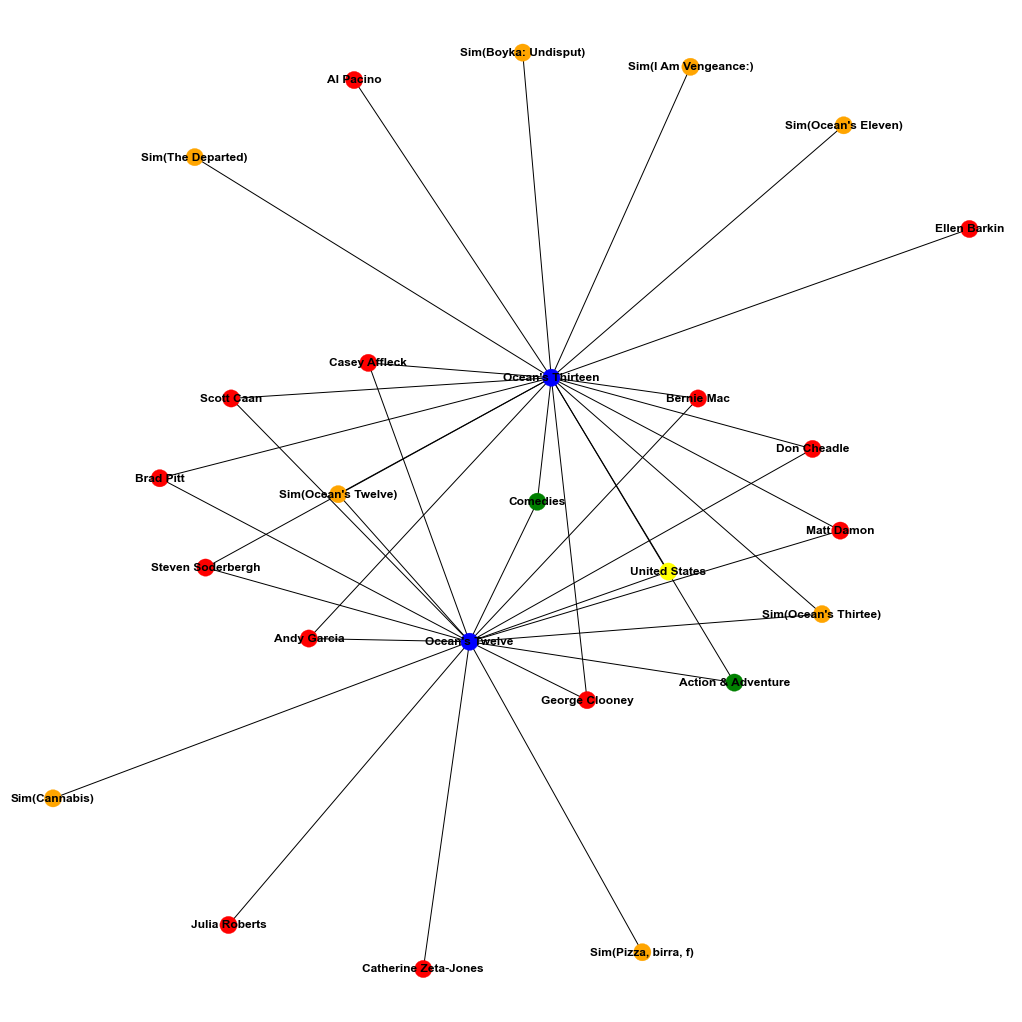

In [14]:
list_in=["Ocean's Twelve","Ocean's Thirteen"]
sub_graph = get_all_adj_nodes(list_in)
draw_sub_graph(sub_graph)

****# The recommendation function
<div class="alert alert-block alert-info">
<li> Explore the neighborhood of the target film <span>&#8594;</span> this is a list of actor, director, country, categorie</li>
<li> Explore the neighborhood of each neighbor <span>&#8594;</span> discover the movies that share a node with the target field</li>
<li> Calcul Adamic Adar measure <span>&#8594;</span> final results</li>
</div>

In [15]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2==root:
                continue
            if G.nodes[e2]['label']=="MOVIE":
                commons = commons_dict.get(e2)
                if commons==None:
                    commons_dict.update({e2 : [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2 : commons})
    movies=[]
    weight=[]
    for key, values in commons_dict.items():
        w=0.0
        for e in values:
            w=w+1/math.log(G.degree(e))
        movies.append(key) 
        weight.append(w)
    
    result = pd.Series(data=np.array(weight),index=movies)
    result.sort_values(inplace=True,ascending=False)        
    return result;

#### Let's test it ...

In [16]:
result = get_recommendation("Ocean's Twelve")
result2 = get_recommendation("Ocean's Thirteen")
result3 = get_recommendation("The Devil Inside")
result4 = get_recommendation("Stranger Things")
print("*"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"*"*40)
print(result.head())
print("*"*40+"\n Recommendation for 'Ocean's Thirteen'\n"+"*"*40)
print(result2.head())
print("*"*40+"\n Recommendation for 'Belmonte'\n"+"*"*40)
print(result3.head())
print("*"*40+"\n Recommendation for 'Stranger Things'\n"+"*"*40)
print(result4.head())

****************************************
 Recommendation for 'Ocean's Twelve'
****************************************
Ocean's Thirteen    7.033613
Ocean's Eleven      1.528732
The Informant!      1.252955
Babel               1.162454
Cannabis            1.116221
dtype: float64
****************************************
 Recommendation for 'Ocean's Thirteen'
****************************************
Ocean's Twelve       7.033613
The Departed         2.232071
Ocean's Eleven       2.086843
Brooklyn's Finest    1.467979
Boyka: Undisputed    1.391627
dtype: float64
****************************************
 Recommendation for 'Belmonte'
****************************************
The Boy                            1.901648
The Devil and Father Amorth        1.413791
Making a Murderer                  1.239666
Love Rhythms - Accidental Daddy    1.116221
I Am Vengeance                     1.116221
dtype: float64
****************************************
 Recommendation for 'Stranger Things'
********

### Draw top recommendations, to see the common nodes

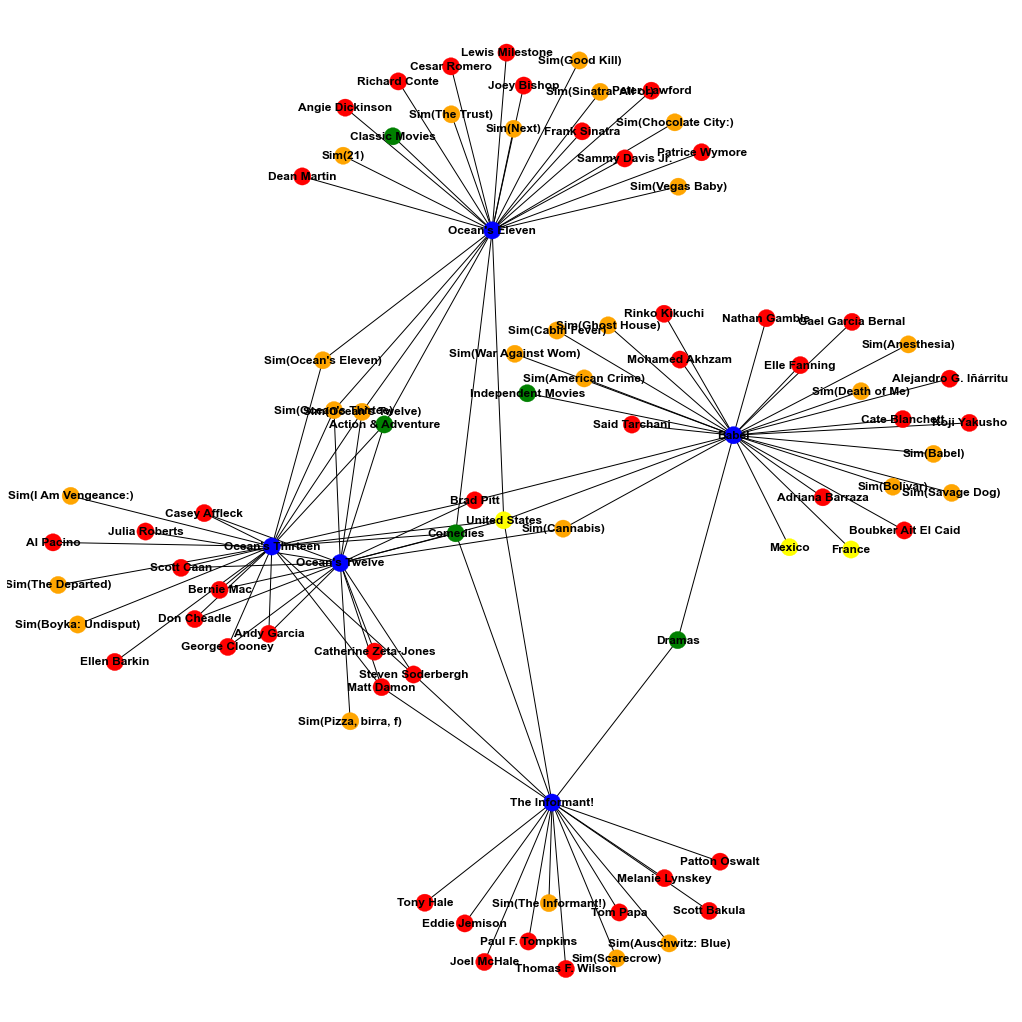

In [17]:
reco=list(result.index[:4].values)
reco.extend(["Ocean's Twelve"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)

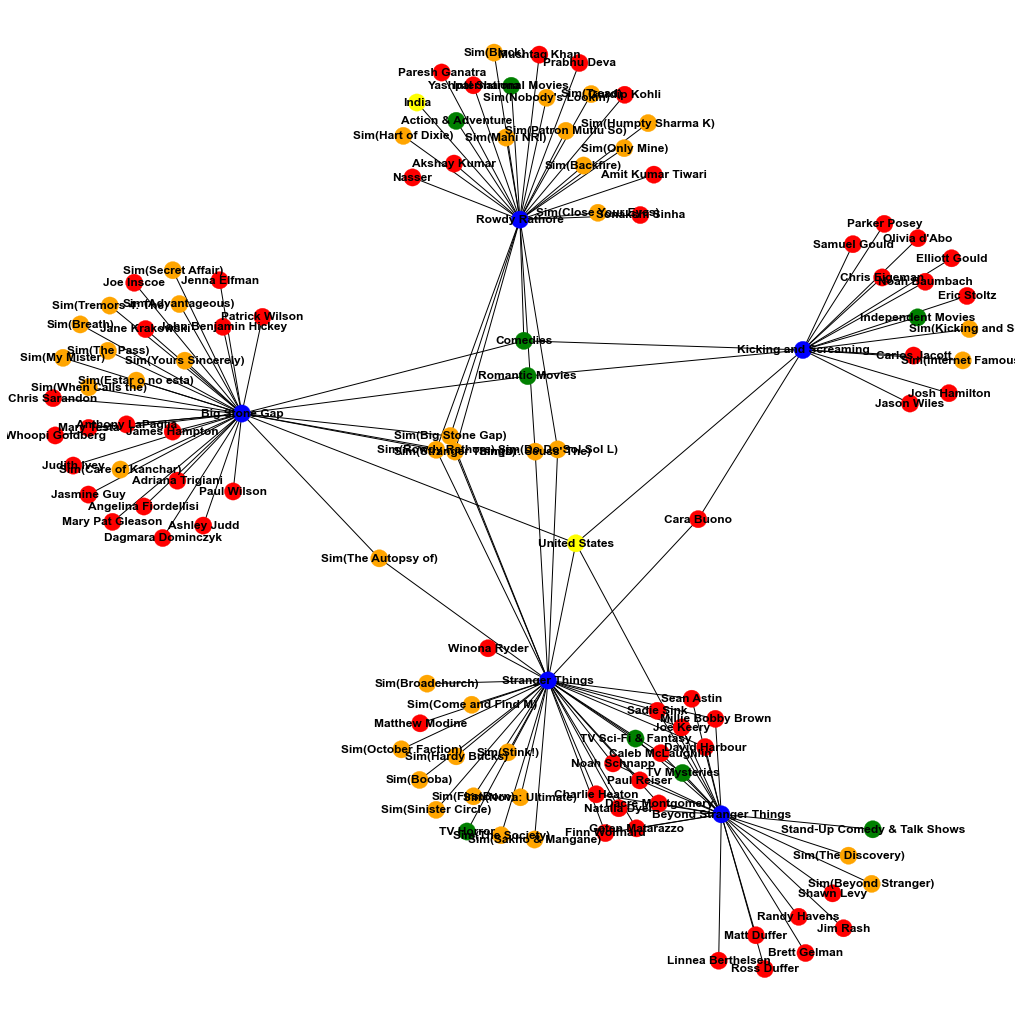

In [18]:
reco=list(result4.index[:4].values)
reco.extend(["Stranger Things"])
sub_graph = get_all_adj_nodes(reco)
draw_sub_graph(sub_graph)